# Forecast the future Income & Expenses for a customer

-------------------------------------

# <a id='1'>1. Introduction</a>

We have a json file that consist of customer transcation. As of now we just have 96 rows & 7 columns. The data contains account and transcations details of single customer. In this exercise we will forecast the Income & expense for the customer for next six months under different Income & Spend categories.

 # <a id='2'>2. Import the necessary libraries </a>

In [1161]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as plt
import json
import holidays
import datetime
import matplotlib.pyplot as plt
from fbprophet import Prophet
# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

 # <a id='3'>3. Retrieving the Data</a>

In [1105]:
data = pd.read_json('data.json', orient='columns')

In [1106]:
data.shape


(96, 7)

# <a id='4'>4. Data Exploration & Manipulation</a>

In [1108]:
data.columns

Index(['accountNo', 'amount', 'bookingDate', 'bookingType', 'booking_id',
       'partnerAccountIBAN', 'user_id'],
      dtype='object')

In [1109]:
print(f"Missing values in each variable: \n{data.isnull().sum()}")

Missing values in each variable: 
accountNo             0
amount                0
bookingDate           0
bookingType           0
booking_id            0
partnerAccountIBAN    0
user_id               0
dtype: int64


In [1110]:
print("List of categories for bookingType:")
print("Total categories: ",len(data.bookingType.unique()))
print("-"*15)
for i in data.bookingType.unique():
    print(i)

List of categories for bookingType:
Total categories:  8
---------------
ATM
Rent
Salary
Installment
Unknown
Childbenefit
GasStation
CarInsurance


## <a id='4-1'>4.1 Creating Features</a>

In [1123]:
data['Dates'] = pd.to_datetime(data['bookingDate']).dt.date
data['Dates'] = pd.to_datetime(data['Dates'], errors='coerce')
data['Time'] = pd.to_datetime(data['bookingDate']).dt.time
data['weekday_name'] = data['Dates'].dt.weekday_name
data['bookingDate'] = pd.to_datetime(data['bookingDate'], errors='coerce')
data['year'] = data['bookingDate'].dt.year
data['month'] = data['bookingDate'].dt.month
data['day'] = data['bookingDate'].dt.day
data['weekday'] = data['Dates'].dt.weekday  # Return week_day as an integer, where Monday is 0 and Sunday is 6.
data['hour'] = data['bookingDate'].dt.hour

In [1124]:
data.head()

,accountNo,amount,bookingDate,bookingType,booking_id,partnerAccountIBAN,user_id,Dates,Time,weekday_name,Holiday,year,month,day,weekday,hour
0,781,-50,2015-07-15 02:00:03,ATM,1,None,106,2015-07-15,02:00:03,Wednesday,False,2015,7,15,2,2
1,781,-1000,2015-07-29 02:00:03,Rent,2,DE513,106,2015-07-29,02:00:03,Wednesday,False,2015,7,29,2,2
2,781,3566,2015-07-29 02:00:03,Salary,3,DE512,106,2015-07-29,02:00:03,Wednesday,False,2015,7,29,2,2
3,781,-160,2015-07-29 02:00:03,Installment,4,DE38900,106,2015-07-29,02:00:03,Wednesday,False,2015,7,29,2,2
4,781,450,2015-07-29 02:00:03,Unknown,5,DE40042,106,2015-07-29,02:00:03,Wednesday,False,2015,7,29,2,2






## <a id='4-2'>4.2 Mark Holidays</a>

In [1125]:
# Assuming the data is for a German customer

de_holidays = holidays.Germany()
data['Holiday'] = data['Dates'].isin(de_holidays)

In [1126]:
data.head(2)

,accountNo,amount,bookingDate,bookingType,booking_id,partnerAccountIBAN,user_id,Dates,Time,weekday_name,Holiday,year,month,day,weekday,hour
0,781,-50,2015-07-15 02:00:03,ATM,1,None,106,2015-07-15,02:00:03,Wednesday,False,2015,7,15,2,2
1,781,-1000,2015-07-29 02:00:03,Rent,2,DE513,106,2015-07-29,02:00:03,Wednesday,False,2015,7,29,2,2


## <a id='4-3'>4.3 Data visualization</a>

----------------------------------

# Recognise Income and Spending patterns of the user

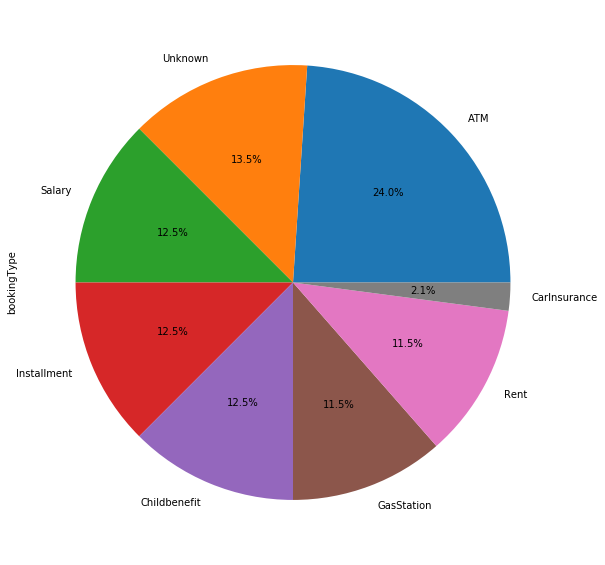

In [1131]:
plt.figure(1, figsize=(10,10))
data['bookingType'].value_counts().head(15).plot.pie(autopct="%1.1f%%")
plt.show()

In [1132]:
itemNames = data['bookingType'].value_counts().index
itemValues = data['bookingType'].value_counts().values

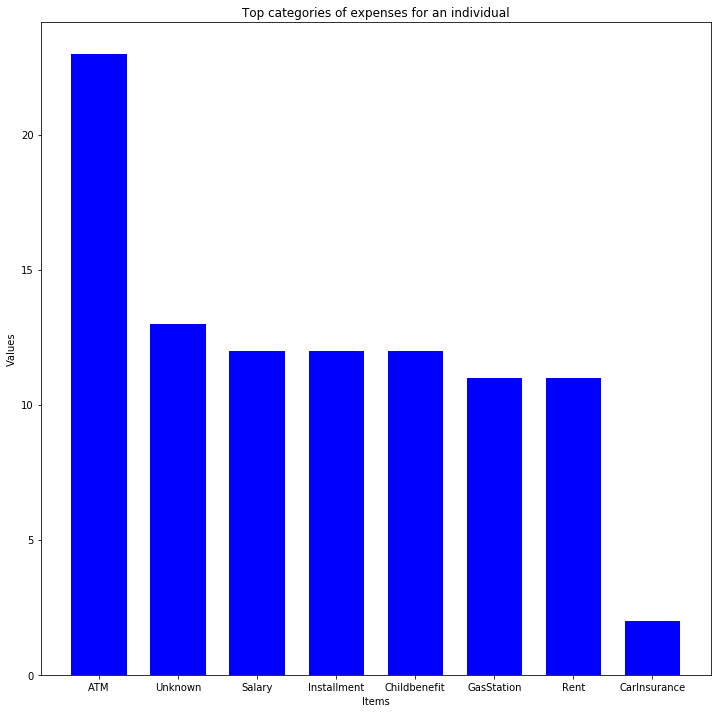

In [1133]:
plt.figure(figsize=(12,12))
plt.ylabel('Values', fontsize='medium')
plt.xlabel('Items', fontsize='medium')
plt.title('Top categories of expenses for an individual')
plt.bar(itemNames[:10],itemValues[:10], width = 0.7, color="blue",linewidth=0.4)
plt.show()

2016    48
2015    48
Name: year, dtype: int64

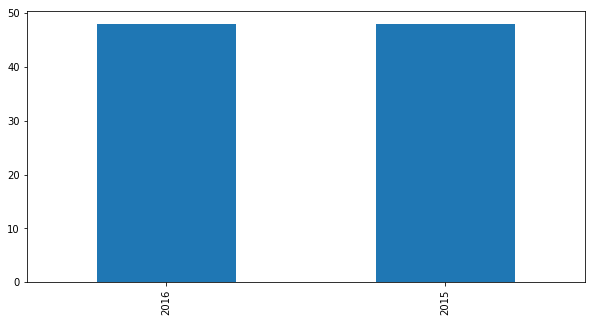

In [1134]:
yearlyTable = data['year'].value_counts().plot(kind='bar',figsize=(10,5))
yearlyTable.set_xlabel("")
data['year'].value_counts().head()

,amount
monthlyTransaction,
2015-07,7
2015-08,8
2015-09,8
2015-10,9
2015-11,8
2015-12,8
2016-01,9
2016-02,8
2016-03,8


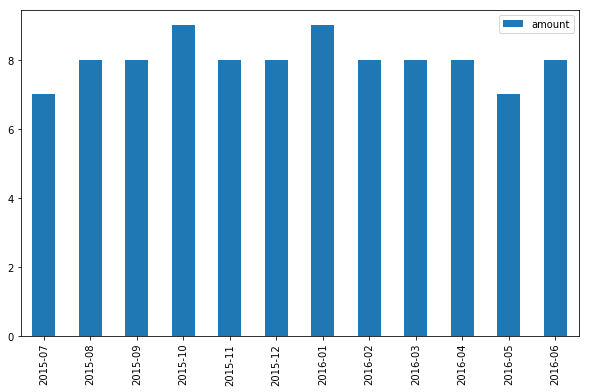

In [1137]:
data['monthlyTransaction'] = pd.to_datetime(data['bookingDate']).dt.to_period('M')
monthlyTransaction = data[['monthlyTransaction','amount']].groupby(['monthlyTransaction'], as_index=False).count().sort_values(by='monthlyTransaction')
monthlyTransaction.set_index('monthlyTransaction' ,inplace=True)

monthlyTable = monthlyTransaction.plot(kind='bar',figsize=(10,6))
monthlyTable.set_xlabel("")

monthlyTransaction

In [1138]:
# Convert the amount to absoulte value..

In [1139]:
data['Absolute_amount']= abs(data['amount'])

In [1141]:
data['monthly'] = pd.to_datetime(data['Dates']).dt.to_period('M')
monthlyTransactionForbookingType = data[['monthly','Absolute_amount', 'bookingType']].groupby(['monthly', 'bookingType'], as_index=False).sum().sort_values(by='monthly')
monthlyTransactionForbookingType.set_index('monthly' ,inplace=True)

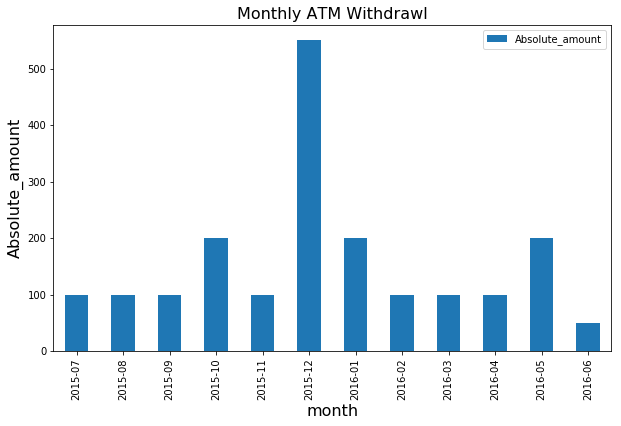

In [1142]:
atm_withdrawls = monthlyTransactionForbookingType[monthlyTransactionForbookingType['bookingType']=='ATM'].plot(kind='bar', figsize=(10,6))
atm_withdrawls.set_xlabel("ATM Withdrawls")

plt.ylabel('Absolute_amount', fontsize=16)
plt.xlabel('month', fontsize=16)
plt.title("Monthly ATM Withdrawl", fontsize=16);

## <b> Mark the Income & Spend Indicators </b>

-----------------------------------

In [1145]:
data['Indicator_In_Sp'] = np.where(data['amount']>0, 'Income', 'Spend')

In [1146]:
pd.pivot_table(data[['Indicator_In_Sp','bookingType','Absolute_amount']], index=['Indicator_In_Sp','bookingType'], aggfunc='sum')

Absolute_amount
Indicator_In_Sp bookingType                  
Income          Childbenefit             2280
                Salary                  51419
                Unknown                 25400
Spend           ATM                      1900
                CarInsurance              320
                GasStation               2042
                Installment              1920
                Rent                    13800

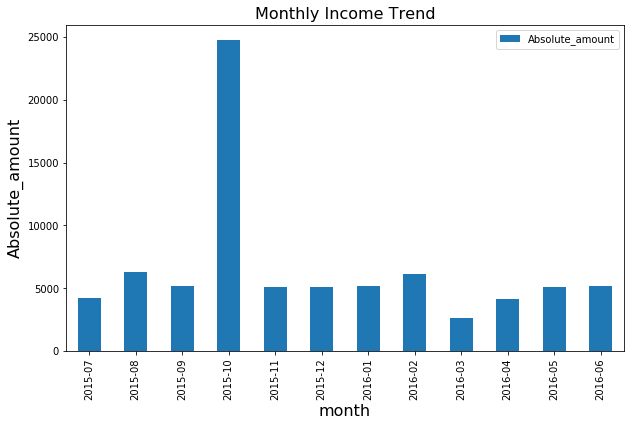

In [1147]:

Income_spend_pattern = data[['monthly','Indicator_In_Sp','bookingType','Absolute_amount']].groupby(['monthly', 'Indicator_In_Sp'], as_index=False).sum().sort_values(by='monthly')
Income_spend_pattern.set_index('monthly' ,inplace=True)
Income_spend_pattern

Income_trend = Income_spend_pattern[Income_spend_pattern['Indicator_In_Sp']=='Income'].plot(kind='bar', figsize=(10,6))
Income_trend.set_xlabel("Income Trend")

plt.ylabel('Absolute_amount', fontsize=16)
plt.xlabel('month', fontsize=16)
plt.title("Monthly Income Trend", fontsize=16);


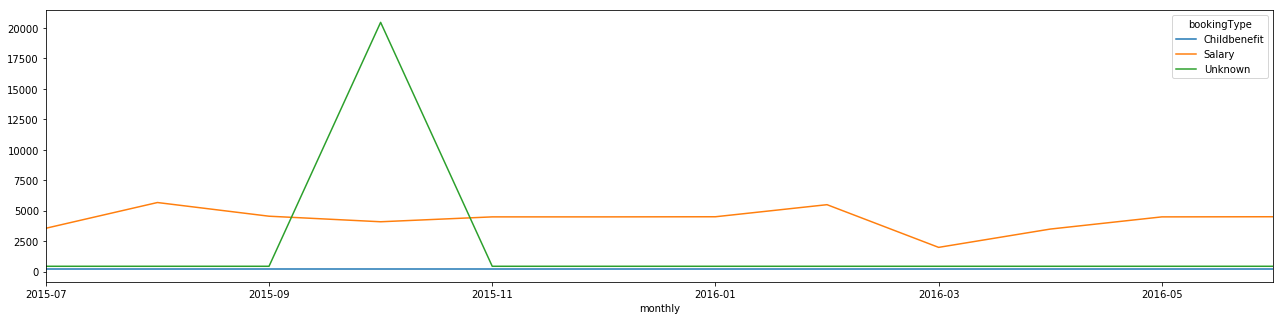

In [1151]:
data.monthly=data.monthly.astype(str)
data_Income = data[['monthly','Indicator_In_Sp','bookingType','Absolute_amount']]

data_Income = data_Income[(data_Income['Indicator_In_Sp'] == 'Income')]

# plot data
fig, ax = plt.subplots(figsize=(22,5))
# use unstack()
data_Income.groupby(['monthly','bookingType']).sum()['Absolute_amount'].unstack().plot(ax=ax)

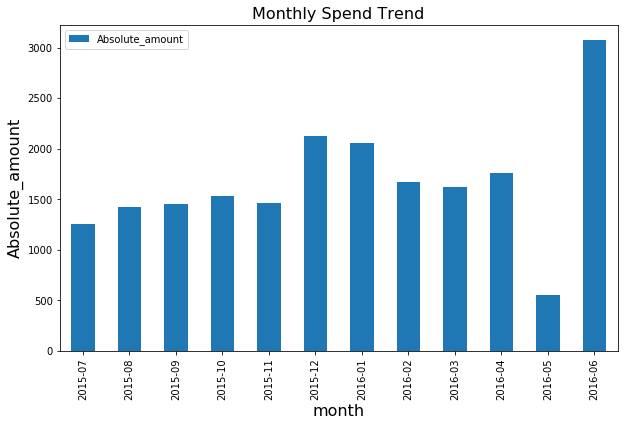

In [1152]:
Income_trend = Income_spend_pattern[Income_spend_pattern['Indicator_In_Sp']=='Spend'].plot(kind='bar', figsize=(10,6))
Income_trend.set_xlabel("Spend Trend")

plt.ylabel('Absolute_amount', fontsize=16)
plt.xlabel('month', fontsize=16)
plt.title("Monthly Spend Trend", fontsize=16);

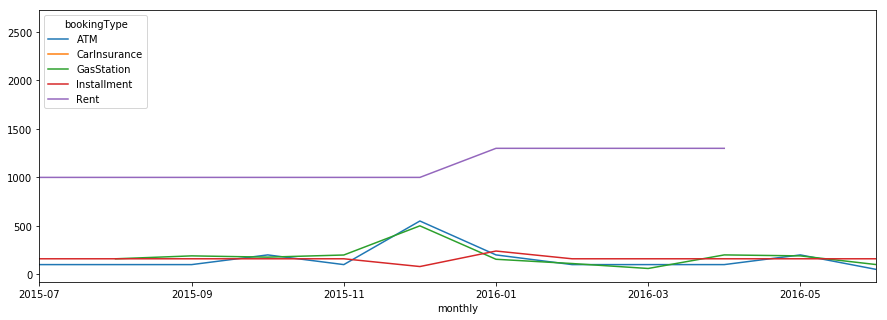

In [1153]:
data_Spend = data[['monthly','Indicator_In_Sp','bookingType','Absolute_amount']]

data_Spend = data_Spend[(data_Spend['Indicator_In_Sp'] == 'Spend')]

# plot data
fig, ax = plt.subplots(figsize=(15,5))
# use unstack()
data_Spend.groupby(['monthly','bookingType']).sum()['Absolute_amount'].unstack().plot(ax=ax)

---------------------------------------

-----------------------------


# <a id='5'>5. Analyze & Forecast different category within Income </a>

--------------------------------------

In [1163]:
Salary = data.loc[data['bookingType'] == 'Salary']
Unknown = data.loc[data['bookingType'] == 'Unknown']
Salary = Salary.sort_values('monthly')
Unknown = Unknown.sort_values('monthly')

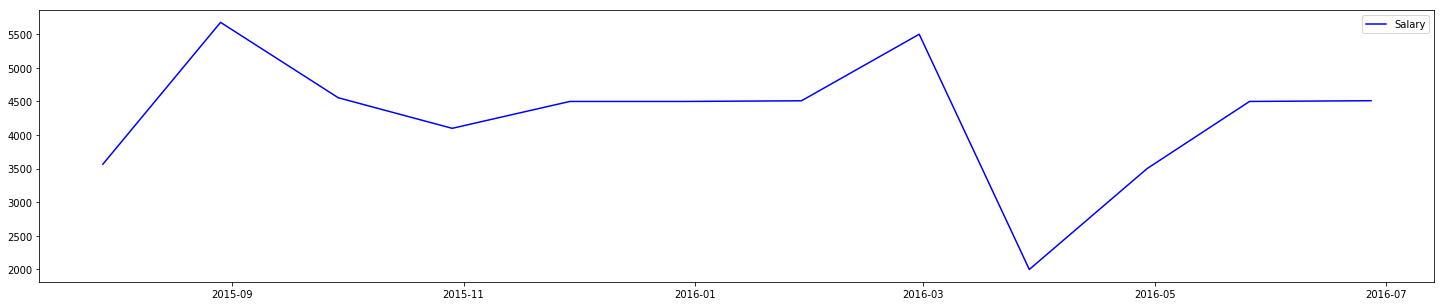

In [1164]:
plt.figure(figsize=(25, 5))
plt.plot(Salary['Dates'], Salary['Absolute_amount'], 'b-', label = 'Salary')

plt.legend();

In [1165]:
cols = ['accountNo','amount','Dates', 'bookingDate', 'bookingType', 'booking_id',
       'partnerAccountIBAN', 'user_id', 'Time', 'weekday_name',
       'Holiday', 'year', 'month', 'day', 'weekday', 'hour',
       'monthlyTransaction', 'Indicator_In_Sp']
Salary.drop(cols, axis=1, inplace=True)
Unknown.drop(cols, axis=1, inplace=True)

## <a id='5-1'>5.1 Salary </a>

## We will be check and update (IF REQUIRED) the outlier & missing value for every category

--------------------------------------

### Outlier Treatment & Forecasting the transaction 

In [1168]:
category=Salary

def out_std(s, nstd=3.0, return_thresholds=False):

    data_mean, data_std = s.mean(), s.std()
    cut_off = data_std * nstd
    lower, upper = data_mean - cut_off, data_mean + cut_off
    if return_thresholds:
        return lower, upper
    else:
        return [True if x < lower or x > upper else False for x in s]
    

outlier_mask = out_std(category['Absolute_amount'], nstd=3.0)

# Identify the outliers, notice these values are on both low and high

category['Absolute_amount'][outlier_mask]



Series([], Name: Absolute_amount, dtype: int64)

In [1169]:
Salary.reset_index(inplace=True,drop = True)
ts = pd.Series(Salary['Absolute_amount'].values, index=Salary['monthly'])

fit1 = ExponentialSmoothing(ts, seasonal_periods=2, trend='add', seasonal='add').fit(use_boxcox=True)

df = pd.DataFrame(np.c_[ts, fit1.level, fit1.slope, fit1.season, fit1.fittedvalues],
                  columns=[r'$y_t$',r'$l_t$',r'$b_t$',r'$s_t$',r'$\hat{y}_t$'],index=ts.index)
df_sal = df.append(fit1.forecast(6).rename(r'$\hat{y}_t$').to_frame(), sort=True)

df_sal.reset_index(inplace=True,drop = True)

def month_inc(data):
    recent_date = data['monthly'].max()
    incr_date = pd.date_range(start=recent_date, periods=6, freq='M')
    columns = ['monthly']
    df = pd.DataFrame(incr_date, columns=columns)
    frames = [data, df]
    result = pd.concat(frames)
    result.reset_index(inplace=True,drop = True)
    return result

Salary_data = month_inc(Salary)

merged_sal = Salary_data.merge(df_sal, left_index=True, right_index=True)

merged_sal = merged_sal[['monthly','Absolute_amount','$\hat{y}_t$']]

sal_names = ['Sal_%s' % column for column in merged_sal.columns]
merged_sal.columns = sal_names
merged_sal.head(2)

,Sal_monthly,Sal_Absolute_amount,Sal_$\hat{y}_t$
0,2015-07,3566.0,3566.0
1,2015-08,5677.0,5677.0


## <a id='5-2'>5.2 Unknown </a>

In [1171]:
category=Unknown

def out_std(s, nstd=3.0, return_thresholds=False):

    data_mean, data_std = s.mean(), s.std()
    cut_off = data_std * nstd
    lower, upper = data_mean - cut_off, data_mean + cut_off
    if return_thresholds:
        return lower, upper
    else:
        return [True if x < lower or x > upper else False for x in s]
    

outlier_mask = out_std(category['Absolute_amount'], nstd=3.0)

# Identify the outliers, notice these values are on both low and high

category['Absolute_amount'][outlier_mask]

#  Unknown['Absolute_amount'].median() [replace outlier with median .i.e 450.0 ]

median = float(category['Absolute_amount'].median())

category["Absolute_amount"] = np.where(category["Absolute_amount"] >=20000, median,category['Absolute_amount'])

In [1172]:
Unknown.reset_index(inplace=True,drop = True)
ts = pd.Series(Unknown['Absolute_amount'].values, index=Unknown['monthly'])
fit1 = ExponentialSmoothing(ts, seasonal_periods=2, trend='add', seasonal='add').fit(use_boxcox=True)

df = pd.DataFrame(np.c_[ts, fit1.level, fit1.slope, fit1.season, fit1.fittedvalues],
                  columns=[r'$y_t$',r'$l_t$',r'$b_t$',r'$s_t$',r'$\hat{y}_t$'],index=ts.index)
df_Unknown = df.append(fit1.forecast(6).rename(r'$\hat{y}_t$').to_frame(), sort=True)

df_Unknown.reset_index(inplace=True,drop = True)

def month_inc(data):
    recent_date = data['monthly'].max()
    incr_date = pd.date_range(start=recent_date, periods=6, freq='M')
    columns = ['monthly']
    df = pd.DataFrame(incr_date, columns=columns)
    frames = [data, df]
    result = pd.concat(frames)
    result.reset_index(inplace=True,drop = True)
    return result

Unknown_data = month_inc(Unknown)

merged_Unknown = Unknown_data.merge(df_Unknown, left_index=True, right_index=True)

merged_Unknown_data = merged_Unknown[['Absolute_amount','$\hat{y}_t$']]

merged_Unknown_names = ['Unknown_%s' % column for column in merged_Unknown_data.columns]
merged_Unknown_data.columns = merged_Unknown_names

merged_Unknown_data.head(2)

,Unknown_Absolute_amount,Unknown_$\hat{y}_t$
0,450.0,450.0
1,450.0,450.0


---------------------------

# <a id='6'>6. Analyze & Forecast different category within Spend </a>

-------------------------------

In [1173]:
ATM = data.loc[data['bookingType'] == 'ATM']
Rent = data.loc[data['bookingType'] == 'Rent']
Installment = data.loc[data['bookingType'] == 'Installment']
GasStation = data.loc[data['bookingType'] == 'GasStation']
CarInsurance = data.loc[data['bookingType'] == 'CarInsurance']

In [1174]:
cols = ['accountNo','amount','Dates', 'bookingDate', 'bookingType', 'booking_id',
       'partnerAccountIBAN', 'user_id', 'Time', 'weekday_name',
       'Holiday', 'year', 'month', 'day', 'weekday', 'hour',
       'monthlyTransaction', 'Indicator_In_Sp']
ATM.drop(cols, axis=1, inplace=True)
Rent.drop(cols, axis=1, inplace=True)
Installment.drop(cols, axis=1, inplace=True)
GasStation.drop(cols, axis=1, inplace=True)
CarInsurance.drop(cols, axis=1, inplace=True)

## <a id='6-1'>6.1 ATM </a>

### Outlier Treatment & Forecasting the transaction

In [1181]:
category=ATM

def out_std(s, nstd=3.0, return_thresholds=False):

    data_mean, data_std = s.mean(), s.std()
    cut_off = data_std * nstd
    lower, upper = data_mean - cut_off, data_mean + cut_off
    if return_thresholds:
        return lower, upper
    else:
        return [True if x < lower or x > upper else False for x in s]
    

outlier_mask = out_std(category['Absolute_amount'], nstd=3.0)

# Identify the outliers, notice these values are on both low and high

category['Absolute_amount'][outlier_mask]


median = float(category['Absolute_amount'].median())

category["Absolute_amount"] = np.where(category["Absolute_amount"] >=500, median,category['Absolute_amount'])

In [1182]:
category_atm = category[['monthly','Absolute_amount']].groupby(['monthly'], as_index=False).sum().sort_values(by='monthly')
category_atm.reset_index(inplace=True,drop = True)

In [1183]:
category=category_atm

category.reset_index(inplace=True,drop = True)
ts = pd.Series(category['Absolute_amount'].values, index=category['monthly'])
fit1 = ExponentialSmoothing(ts, seasonal_periods=2, trend='add', seasonal='add').fit(use_boxcox=True)

df = pd.DataFrame(np.c_[ts, fit1.level, fit1.slope, fit1.season, fit1.fittedvalues],
                  columns=[r'$y_t$',r'$l_t$',r'$b_t$',r'$s_t$',r'$\hat{y}_t$'],index=ts.index)
df_category = df.append(fit1.forecast(6).rename(r'$\hat{y}_t$').to_frame(), sort=True)

df_category.reset_index(inplace=True,drop = True)

def month_inc(data):
    recent_date = data['monthly'].max()
    incr_date = pd.date_range(start=recent_date, periods=6, freq='M')
    columns = ['monthly']
    df = pd.DataFrame(incr_date, columns=columns)
    frames = [data, df]
    result = pd.concat(frames)
    result.reset_index(inplace=True,drop = True)
    return result

category_data = month_inc(category)

merged_category = category_data.merge(df_category, left_index=True, right_index=True)

merged_atm_data = merged_category[['Absolute_amount','$\hat{y}_t$']]

merged_ATM_names = ['ATM_%s' % column for column in merged_atm_data.columns]
merged_atm_data.columns = merged_ATM_names

merged_atm_data.head(2)

,ATM_Absolute_amount,ATM_$\hat{y}_t$
0,100.0,118.663965
1,100.0,129.240408


## <a id='6-2'>6.2 Rent </a>

In [1184]:
Rent = Rent.append({'Absolute_amount' : 1 , 'monthly' : '2016-05'} , ignore_index=True)
category=Rent


def out_std(s, nstd=3.0, return_thresholds=False):

    data_mean, data_std = s.mean(), s.std()
    cut_off = data_std * nstd
    lower, upper = data_mean - cut_off, data_mean + cut_off
    if return_thresholds:
        return lower, upper
    else:
        return [True if x < lower or x > upper else False for x in s]
    

outlier_mask = out_std(category['Absolute_amount'], nstd=3.0)

# Identify the outliers, notice these values are on both low and high

category['Absolute_amount'][outlier_mask]

Series([], Name: Absolute_amount, dtype: int64)

In [1185]:
category=Rent

category.reset_index(inplace=True,drop = True)
ts = pd.Series(category['Absolute_amount'].values, index=category['monthly'])
fit1 = ExponentialSmoothing(ts, seasonal_periods=2, trend='add', seasonal='add').fit(use_boxcox=True)

df = pd.DataFrame(np.c_[ts, fit1.level, fit1.slope, fit1.season, fit1.fittedvalues],
                  columns=[r'$y_t$',r'$l_t$',r'$b_t$',r'$s_t$',r'$\hat{y}_t$'],index=ts.index)
df_Rent = df.append(fit1.forecast(6).rename(r'$\hat{y}_t$').to_frame(), sort=True)

df_Rent.reset_index(inplace=True,drop = True)

def month_inc(data):
    recent_date = data['monthly'].max()
    incr_date = pd.date_range(start=recent_date, periods=6, freq='BM')
    columns = ['monthly']
    df = pd.DataFrame(incr_date, columns=columns)
    frames = [data, df]
    result = pd.concat(frames)
    result.reset_index(inplace=True,drop = True)
    return result

Rent_data = month_inc(category)

merged_Rent = Rent_data.merge(df_Rent, left_index=True, right_index=True)

merged_Rent_data = merged_Rent[['Absolute_amount','$\hat{y}_t$']]

merged_Rent_names = ['Rent_%s' % column for column in merged_Rent_data.columns]
merged_Rent_data.columns = merged_Rent_names

merged_Rent_data.head(2)

,Rent_Absolute_amount,Rent_$\hat{y}_t$
0,1000.0,1000.0
1,1000.0,1000.0


## <a id='6-3'>6.3 GasStation </a>

In [1186]:
category=GasStation

def out_std(s, nstd=3.0, return_thresholds=False):

    data_mean, data_std = s.mean(), s.std()
    cut_off = data_std * nstd
    lower, upper = data_mean - cut_off, data_mean + cut_off
    if return_thresholds:
        return lower, upper
    else:
        return [True if x < lower or x > upper else False for x in s]
    

outlier_mask = out_std(category['Absolute_amount'], nstd=3.0)

# Identify the outliers, notice these values are on both low and high

category['Absolute_amount'][outlier_mask]

Series([], Name: Absolute_amount, dtype: int64)

In [1197]:
category=GasStation

category.reset_index(inplace=True,drop = True)
ts = pd.Series(category['Absolute_amount'].values, index=category['monthly'])
fit1 = ExponentialSmoothing(ts, seasonal_periods=2, trend='add', seasonal='add').fit(use_boxcox=True)

df = pd.DataFrame(np.c_[ts, fit1.level, fit1.slope, fit1.season, fit1.fittedvalues],
                  columns=[r'$y_t$',r'$l_t$',r'$b_t$',r'$s_t$',r'$\hat{y}_t$'],index=ts.index)
df_Rent = df.append(fit1.forecast(6).rename(r'$\hat{y}_t$').to_frame(), sort=True)

df_Rent.reset_index(inplace=True,drop = True)

def month_inc(data):
    recent_date = data['monthly'].max()
    incr_date = pd.date_range(start=recent_date, periods=6, freq='BMMa ')
    columns = ['monthly']
    df = pd.DataFrame(incr_date, columns=columns)
    frames = [data, df]
    result = pd.concat(frames)
    result.reset_index(inplace=True,drop = True)
    return result

GasStation_data = month_inc(category)

merged_GasStation = GasStation_data.merge(df_Rent, left_index=True, right_index=True)

merged_GasStation_data = merged_GasStation[['Absolute_amount','$\hat{y}_t$']]

merged_GasStation_names = ['Gas_%s' % column for column in merged_GasStation_data.columns]
merged_GasStation_data.columns = merged_GasStation_names

,Gas_Absolute_amount,Gas_$\hat{y}_t$
0,160.0,208.218959
1,190.0,166.147168
2,177.0,201.979032
3,199.0,164.641293
4,500.0,202.171533
5,155.0,197.537848
6,111.0,230.599902
7,60.0,170.553992
8,200.0,165.470311
9,190.0,139.337221


## <a id='6-4'>6.4 Installment </a>

In [1188]:
category=Installment

def out_std(s, nstd=3.0, return_thresholds=False):

    data_mean, data_std = s.mean(), s.std()
    cut_off = data_std * nstd
    lower, upper = data_mean - cut_off, data_mean + cut_off
    if return_thresholds:
        return lower, upper
    else:
        return [True if x < lower or x > upper else False for x in s]
    

outlier_mask = out_std(category['Absolute_amount'], nstd=3.0)

# Identify the outliers, notice these values are on both low and high

category['Absolute_amount'][outlier_mask]

Series([], Name: Absolute_amount, dtype: int64)

In [1189]:
category=Installment

category.reset_index(inplace=True,drop = True)
ts = pd.Series(category['Absolute_amount'].values, index=category['monthly'])
fit1 = ExponentialSmoothing(ts, seasonal_periods=2, trend='add', seasonal='add').fit(use_boxcox=True)

df = pd.DataFrame(np.c_[ts, fit1.level, fit1.slope, fit1.season, fit1.fittedvalues],
                  columns=[r'$y_t$',r'$l_t$',r'$b_t$',r'$s_t$',r'$\hat{y}_t$'],index=ts.index)
df_Rent = df.append(fit1.forecast(6).rename(r'$\hat{y}_t$').to_frame(), sort=True)

df_Rent.reset_index(inplace=True,drop = True)

def month_inc(data):
    recent_date = data['monthly'].max()
    incr_date = pd.date_range(start=recent_date, periods=6, freq='BM')
    columns = ['monthly']
    df = pd.DataFrame(incr_date, columns=columns)
    frames = [data, df]
    result = pd.concat(frames)
    result.reset_index(inplace=True,drop = True)
    return result

Installment_data = month_inc(category)

merged_Installment = Installment_data.merge(df_Rent, left_index=True, right_index=True)

merged_Installment_data = merged_Installment[['Absolute_amount','$\hat{y}_t$']]



Installment_names = ['Install_%s' % column for column in merged_Installment_data.columns]
merged_Installment_data.columns = Installment_names

merged_Installment_data.head(2)

,Install_Absolute_amount,Install_$\hat{y}_t$
0,160.0,160.0
1,160.0,160.0


---------------------------------

 # <a id='Yeah 7'>7. Combining the Forecast for all the categories </a>

--------

In [1198]:
data_set = data[['accountNo']].head(17)


In [1199]:
df_final = pd.concat([data_set,merged_sal,merged_Unknown_data,merged_atm_data,
                     merged_Rent_data,merged_GasStation_data,merged_Installment_data],axis=1,sort=False).reset_index()

In [1200]:
df_final['Monthly'] = pd.to_datetime(df_final['Sal_monthly']).dt.to_period('M')

Final_Forecast_value = df_final[['accountNo','Monthly','Sal_Absolute_amount',
       'Sal_$\hat{y}_t$', 'Unknown_Absolute_amount', 'Unknown_$\hat{y}_t$',
       'ATM_Absolute_amount', 'ATM_$\hat{y}_t$', 'Rent_Absolute_amount',
       'Rent_$\hat{y}_t$', 'Gas_Absolute_amount', 'Gas_$\hat{y}_t$',
       'Install_Absolute_amount', 'Install_$\hat{y}_t$']]

Final_Forecast_value.drop(Final_Forecast_value.tail(1).index,inplace=True)

## The below table has 

### 1. Absolute_amount --- Actual Amount
### 2.  𝑦̂ 𝑡  ----  Fitted values 

In [1218]:
Final_Forecast_value.tail()


,accountNo,Monthly,Sal_Absolute_amount,Sal_$\hat{y}_t$,Unknown_Absolute_amount,Unknown_$\hat{y}_t$,ATM_Absolute_amount,ATM_$\hat{y}_t$,Rent_Absolute_amount,Rent_$\hat{y}_t$,Gas_Absolute_amount,Gas_$\hat{y}_t$,Install_Absolute_amount,Install_$\hat{y}_t$
13,781.0,2016-07,NaN,4434.265312,NaN,450.0,NaN,74.762194,NaN,956.503934,NaN,119.479809,NaN,160.400599
14,781.0,2016-08,NaN,3538.345352,NaN,450.0,NaN,67.089813,NaN,953.594139,NaN,137.186589,NaN,160.423579
15,781.0,2016-09,NaN,4356.306583,NaN,450.0,NaN,60.238694,NaN,950.687706,NaN,112.012061,NaN,160.446559
16,781.0,2016-10,NaN,3437.507773,NaN,450.0,NaN,54.117337,NaN,947.784637,NaN,128.492554,NaN,160.469538
17,NaN,2016-11,NaN,4276.763362,NaN,450.0,NaN,48.644830,NaN,944.884936,NaN,NaN,NaN,160.492516


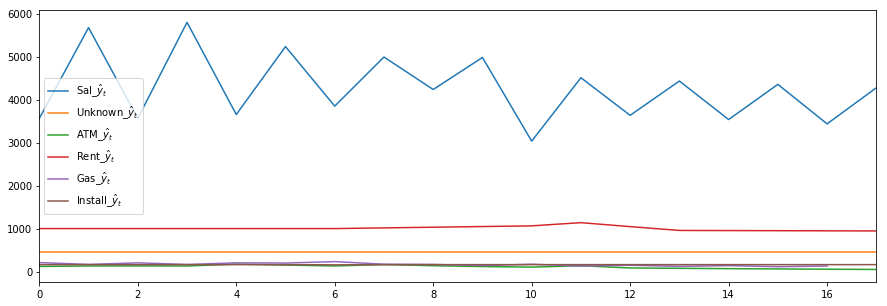

In [1216]:
cols= ['Sal_$\hat{y}_t$','Unknown_$\hat{y}_t$','ATM_$\hat{y}_t$','Rent_$\hat{y}_t$','Gas_$\hat{y}_t$','Install_$\hat{y}_t$']
Final_Forecast_value[cols] = Final_Forecast_value[cols].apply(pd.to_numeric, errors='coerce')

Final_Forecast_fig = Final_Forecast_value[['Monthly','Sal_$\hat{y}_t$','Unknown_$\hat{y}_t$','ATM_$\hat{y}_t$','Rent_$\hat{y}_t$','Gas_$\hat{y}_t$','Install_$\hat{y}_t$']]
# plot data
fig, ax = plt.subplots(figsize=(15,5))
Final_Forecast_fig.plot(ax=ax)